In [ ]:
# Run this in Colab. Installs and imports.
!pip install gymnasium box2d-py >/dev/null 2>&1 || true
!pip install gymnasium[box2d] >/dev/null 2>&1 || true
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu >/dev/null 2>&1 || true
!pip install matplotlib numpy pandas >/dev/null 2>&1 || true

import math
import random
import time
from collections import defaultdict, deque

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import gymnasium as gym
import torch
import torch.nn as nn
import torch.optim as optim

# set seed for reproducibility
SEED = 123
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

print('Setup complete')

Setup complete


# 🧠 1 — Quick Theory: MDPs, Temporal Credit Assignment & Reward Shaping

Reinforcement Learning (RL) is about **learning through interaction** — an agent acts in an environment and improves its behavior (policy) to maximize long-term rewards.  
RL problems are formalized as **Markov Decision Processes (MDPs).**

---

## 🔹 MDP Recap

An **MDP** is defined by the tuple:

**(S, A, P, R, γ)**

- **S** — set of possible **states**  
- **A** — set of **actions** available to the agent  
- **P(s'|s,a)** — **transition probability** of reaching next state `s'` from state `s` after action `a`  
- **R(s,a,s')** — **reward function**  
- **γ (gamma)** — **discount factor**, controlling the importance of future rewards  

🎯 **Goal:**  
The agent aims to find a policy π(a|s) that maximizes the **expected discounted return**:

> G = E[ R₀ + γR₁ + γ²R₂ + ... ]  
> or equivalently,  
> G = E[ Σ (γᵗ * Rₜ) ]

This represents the total reward accumulated over time, where future rewards are discounted by γ (0 ≤ γ < 1) to emphasize immediate rewards more strongly.

---

## 🔹 Temporal Credit Assignment

**Problem:** How can the agent figure out *which past actions* were responsible for *future rewards*?

Example — a robot reaches the goal at the end of a maze. Which early actions made that success possible?

Different RL methods solve this differently:

| Technique | Key Idea | Example Algorithms |
|------------|-----------|--------------------|
| **Bootstrapping** | Update current value using estimates of future returns | TD(0), Q-Learning |
| **Monte Carlo Returns** | Use full-episode returns (no bootstrapping) | Monte Carlo Control |
| **Eligibility Traces** | Combine both short- and long-term updates | TD(λ), SARSA(λ) |
| **Policy Gradient** | Directly optimize the policy using gradients | REINFORCE, A2C, PPO |

These methods define *how feedback propagates through time* to improve decision making.

---

## 🔹 Reward Shaping

Learning can be slow if rewards are **sparse** (e.g., only getting +1 at the end of a long episode).  
**Reward shaping** modifies the reward function to provide *denser, more informative feedback* — helping the agent learn faster.

### Potential-Based Reward Shaping

We add an auxiliary term `F(s,a,s')` based on a *potential function* Φ(s):

> F(s,a,s') = γ * Φ(s') - Φ(s)  
> R'(s,a,s') = R(s,a,s') + F(s,a,s')

✅ This preserves the **optimal policy** (the best solution remains the same),  
but accelerates learning by providing additional guidance.

**Advantages:**
- Speeds up convergence in sparse-reward tasks  
- Encourages smoother exploration  

**Cautions:**
- Poorly chosen shaping can bias or mislead learning  
- Use *potential-based* functions to avoid changing the true objective  

---

# ❄️ 2 — Tabular Q-Learning: FrozenLake (Discrete)

Now we’ll implement **Tabular Q-Learning**, a foundational algorithm for learning optimal policies in discrete MDPs.

The **Q-function** represents the expected return of taking action `a` in state `s` and following the current policy:

> Q(s,a) = expected future reward from (s,a)

At each step, we update:

> Q(s,a) ← Q(s,a) + α * [ R + γ * maxₐ' Q(s',a') - Q(s,a) ]

where  
- **α** = learning rate  
- **γ** = discount factor  
- **R** = observed reward  

---

We’ll train the Q-learning agent in **FrozenLake-v1** and compare:

1. **Default reward** — sparse (only +1 when reaching goal).  
2. **Shaped reward** — dense (extra intermediate rewards for progress).

This will show how **reward design** affects learning speed, stability, and exploration.


Q-learning implementation (tabular)

In [ ]:
def q_learning(env, num_episodes=2000, alpha=0.8, gamma=0.99, epsilon=0.1, reward_shaper=None):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(num_episodes):
        s, _ = env.reset()
        done = False
        total_r = 0
        steps = 0
        while not done and steps < 200:
            # epsilon-greedy
            if random.random() < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s])

            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            # optional shaping
            if reward_shaper:
                r = reward_shaper(s, a, s2, r)

            total_r += r

            # Q update
            Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s2]) - Q[s, a])

            s = s2
            steps += 1

        rewards.append(total_r)

    return Q, rewards

In [ ]:
# Create environment (slippery FrozenLake variants available in gymnasium)
env = gym.make('FrozenLake-v1', is_slippery=False)  # deterministic for clarity
env.reset(seed=SEED)

nS = env.observation_space.n
nA = env.action_space.n
print('States:', nS, 'Actions:', nA)

States: 16 Actions: 4


Define two reward shaping functions

In [ ]:
# 1) Identity (no shaping)
def identity_shaper(s, a, s2, r):
    return r

# 2) Dense shaping: small negative step penalty, big positive for goal

def dense_shaper(s, a, s2, r):
    # environment gives r=1 on reaching goal, 0 otherwise
    # give small -0.01 per step to encourage shorter paths
    step_penalty = -0.01
    return r + step_penalty

Train and compare

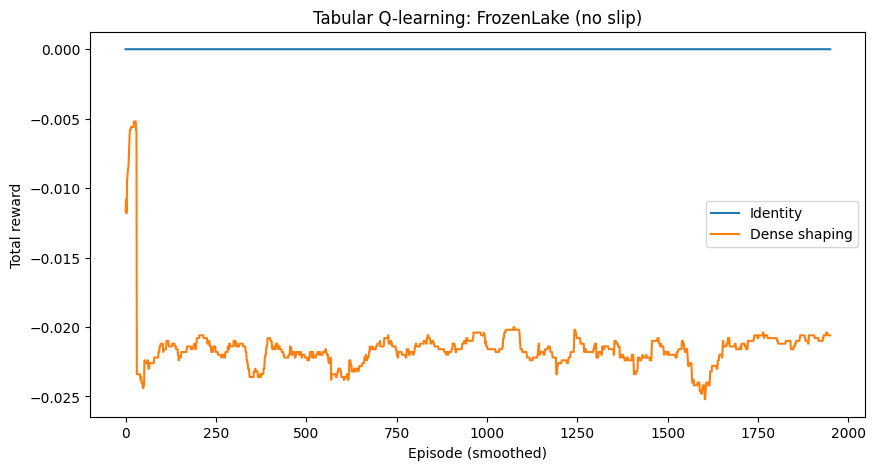

In [ ]:
Q_id, rewards_id = q_learning(env, num_episodes=2000, alpha=0.8, gamma=0.99, epsilon=0.1, reward_shaper=identity_shaper)
Q_dense, rewards_dense = q_learning(env, num_episodes=2000, alpha=0.8, gamma=0.99, epsilon=0.1, reward_shaper=dense_shaper)

# smooth and plot
def smooth(x, window=50):
    return np.convolve(x, np.ones(window)/window, mode='valid')

plt.figure(figsize=(10,5))
plt.plot(smooth(rewards_id), label='Identity')
plt.plot(smooth(rewards_dense), label='Dense shaping')
plt.xlabel('Episode (smoothed)')
plt.ylabel('Total reward')
plt.legend()
plt.title('Tabular Q-learning: FrozenLake (no slip)')
plt.show()

In [ ]:
# Install the necessary dependency to render the environment for video generation
!pip install gymnasium[box2d] >/dev/null 2>&1 || true

# Function to save frames and create a video
def generate_video(env, policy, filename="cartpole.mp4", episodes=1):
    import moviepy.editor as mp
    from moviepy.video.io.ImageSequenceClip import ImageSequenceClip

    frames = []
    for ep in range(episodes):
        s, _ = env.reset()
        done = False
        while not done:
            frame = env.render()
            frames.append(frame)
            s_v = torch.tensor(s, dtype=torch.float32).unsqueeze(0)
            probs = policy(s_v).detach().numpy()[0]
            a = np.random.choice(len(probs), p=probs) # Use random sampling based on probability
            s, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

    env.close() # Close the environment after rendering

    if frames:
        clip = ImageSequenceClip(frames, fps=30) # 30 fps
        clip.write_videofile(filename, fps=30)
        print(f"Video saved as {filename}")
    else:
        print("No frames captured to create video.")

# Example usage after training:
# Assuming 'policy' is your trained policy network for CartPole
# generate_video(gym.make('CartPole-v1', render_mode='rgb_array'), policy, episodes=1)

# Q-learning on martian rover:


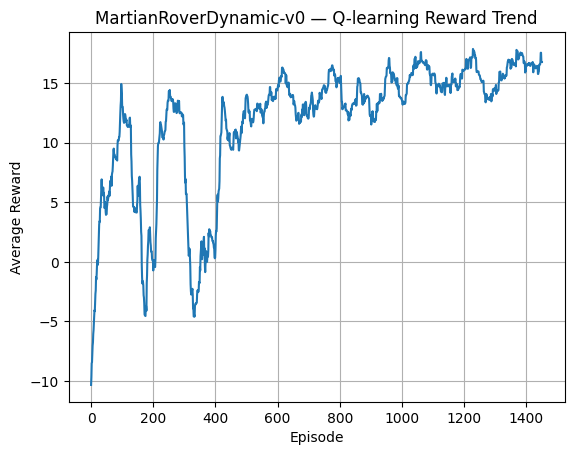

  logger.warn(



=== Testing Learned Policy on MartianRoverDynamic-v0 ===
 .  R  .  .  .  . 
 .  .  X  .  .  . 
 .  X  .  .  .  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  R  .  .  . 
 .  .  X  .  .  . 
 .  X  .  .  .  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  R  .  . 
 .  .  X  .  .  . 
 .  X  .  .  .  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  R  .  . 
 .  .  X  .  .  . 
 .  X  .  .  .  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  .  R  . 
 .  .  X  .  .  . 
 .  X  .  .  .  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  .  .  . 
 .  .  X  .  R  . 
 .  X  .  .  .  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  .  .  . 
 .  .  X  .  .  . 
 .  X  .  .  R  . 
 .  X  .  .  .  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  .  .  . 
 .  .  X  .  .  . 
 .  X  .  .  .  . 
 .  X  .  .  R  . 
 .  .  .  X  .  . 
 .  .  .  .  .  G 

 .  .  .  .  .  . 
 .  

In [ ]:
# =========================================
# 🧠 Martian Rover Dynamic Environment (v0)
# Q-learning demonstration (discrete)
# =========================================

!pip install gymnasium numpy matplotlib -q

import gymnasium as gym
from gymnasium import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
from gymnasium.envs.registration import register

# ------------------------------------------
# 🌍 Define the Martian Rover Dynamic Environment
# ------------------------------------------
class MartianRoverDynamicEnv(gym.Env):
    metadata = {"render_modes": ["human"]}

    def __init__(self, grid_size=6):
        super().__init__()
        self.grid_size = grid_size
        self.observation_space = spaces.Discrete(grid_size * grid_size)
        self.action_space = spaces.Discrete(4)  # up, right, down, left

        # Define start, goal, and hazards
        self.start = 0
        self.goal = grid_size * grid_size - 1
        self.hazards = {8, 13, 19, 27}

        self.pos = self.start

        # Dynamic factors (simulating sandstorm drift)
        self.wind_prob = 0.15  # 15% chance per step to drift randomly

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.pos = self.start
        return self.pos, {}

    def step(self, action):
        row, col = divmod(self.pos, self.grid_size)

        # Execute action
        if action == 0 and row > 0:
            row -= 1  # up
        elif action == 1 and col < self.grid_size - 1:
            col += 1  # right
        elif action == 2 and row < self.grid_size - 1:
            row += 1  # down
        elif action == 3 and col > 0:
            col -= 1  # left

        new_pos = row * self.grid_size + col

        # Dynamic effect: random wind drift
        if random.random() < self.wind_prob:
            drift = random.choice([-1, 1])
            if 0 <= new_pos + drift < self.grid_size * self.grid_size:
                new_pos += drift  # minor random shift

        reward = -1  # small step penalty
        terminated = False

        if new_pos in self.hazards:
            reward = -10
            terminated = True
        elif new_pos == self.goal:
            reward = 30
            terminated = True

        self.pos = new_pos
        return self.pos, reward, terminated, False, {}

    def render(self):
        grid = np.full((self.grid_size, self.grid_size), " . ")
        for h in self.hazards:
            r, c = divmod(h, self.grid_size)
            grid[r, c] = " X "
        r, c = divmod(self.goal, self.grid_size)
        grid[r, c] = " G "
        r, c = divmod(self.pos, self.grid_size)
        grid[r, c] = " R "
        print("\n".join(["".join(row) for row in grid]))
        print()

# ------------------------------------------
# 🔧 Register the environment
# ------------------------------------------
register(
    id="MartianRoverDynamic-v0",
    entry_point=MartianRoverDynamicEnv,
)

# ------------------------------------------
# ⚙️ Q-learning function (from your code)
# ------------------------------------------
def q_learning(env, num_episodes=2000, alpha=0.8, gamma=0.99, epsilon=0.1, reward_shaper=None):
    Q = np.zeros((env.observation_space.n, env.action_space.n))
    rewards = []

    for ep in range(num_episodes):
        s, _ = env.reset()
        done = False
        total_r = 0
        steps = 0
        while not done and steps < 200:
            # epsilon-greedy policy
            if random.random() < epsilon:
                a = env.action_space.sample()
            else:
                a = np.argmax(Q[s])

            s2, r, terminated, truncated, info = env.step(a)
            done = terminated or truncated

            if reward_shaper:
                r = reward_shaper(s, a, s2, r)

            total_r += r

            # Q-update rule
            Q[s, a] = Q[s, a] + alpha * (r + gamma * np.max(Q[s2]) - Q[s, a])
            s = s2
            steps += 1

        rewards.append(total_r)

    return Q, rewards

# ------------------------------------------
# 🚀 Train the Q-learning agent
# ------------------------------------------
env = gym.make("MartianRoverDynamic-v0")
Q, rewards = q_learning(env, num_episodes=1500)

# ------------------------------------------
# 📈 Plot training performance
# ------------------------------------------
plt.plot(np.convolve(rewards, np.ones(50)/50, mode='valid'))
plt.title("MartianRoverDynamic-v0 — Q-learning Reward Trend")
plt.xlabel("Episode")
plt.ylabel("Average Reward")
plt.grid(True)
plt.show()

# ------------------------------------------
# 🧩 Test the learned policy
# ------------------------------------------
s, _ = env.reset()
done = False
steps = 0
print("=== Testing Learned Policy on MartianRoverDynamic-v0 ===")
while not done and steps < 25:
    a = np.argmax(Q[s])
    s, r, terminated, truncated, info = env.step(a)
    done = terminated or truncated
    env.render()
    steps += 1
